Text(0.5, 1.0, 'by hour')

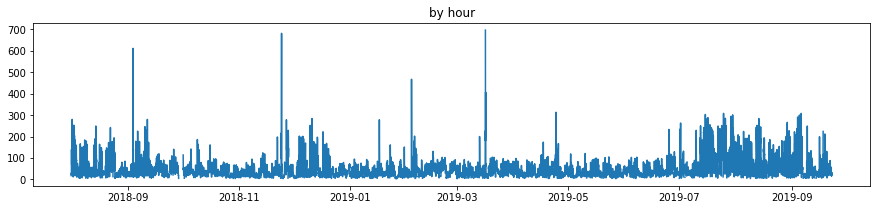

In [2]:
# load JSON
import json
import pandas as pd
import numpy as np

# hourly data 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
data = data.sort_values(by=['ds'])
data['just_date'] = data['ds'].dt.date
temp = data.iloc[-1,:]
firstDate = temp['just_date']

n_samples = 10000
t_start = len(data) - n_samples
df_h = data[t_start:(t_start+n_samples)]

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
#plt.figure(figsize=(15,3))
#plt.plot(df_d['ds'],df_d['y'])
#plt.title('by date')
plt.figure(figsize=(15,3))
plt.plot(df_h['ds'],df_h['y'])
plt.title('by hour')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


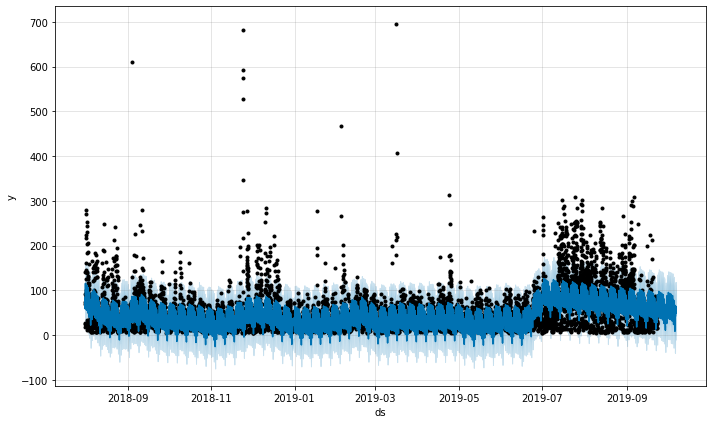

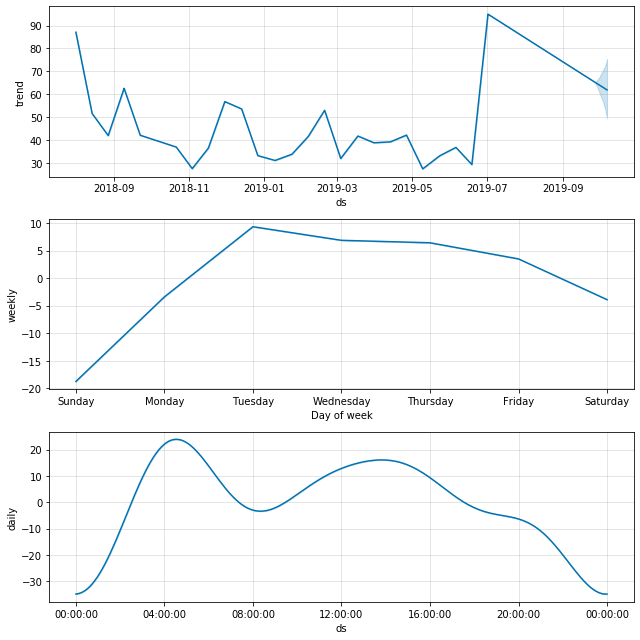

In [3]:
df = df_h # select daily or hourly daya
n_prd = 336

from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=n_prd, freq='H')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)
#test = data[(t_start+n_samples):(t_start+n_samples+n_prd)]
#plt.plot(test['ds'],test['y'],color='r')

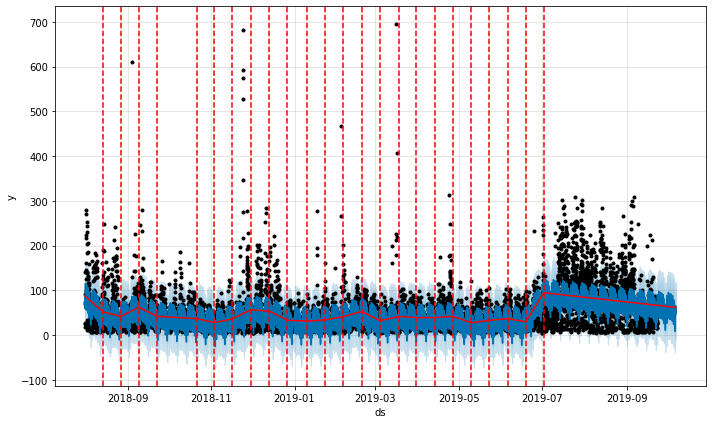

In [4]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
#plt.xlim('2019-09-20','2019-10-20')

In [5]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon ='30 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 20 forecasts with cutoffs between 2018-11-11 19:00:00 and 2019-08-23 19:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-11-11 20:00:00,17.732352,-16.866216,54.770758,15.0,2018-11-11 19:00:00
1,2018-11-11 21:00:00,11.084098,-25.667494,49.903586,11.0,2018-11-11 19:00:00
2,2018-11-11 22:00:00,3.475616,-34.646033,37.910097,6.0,2018-11-11 19:00:00
3,2018-11-12 00:00:00,-3.723581,-38.432705,31.652466,5.0,2018-11-11 19:00:00
4,2018-11-12 01:00:00,3.254404,-31.244502,38.833875,7.0,2018-11-11 19:00:00


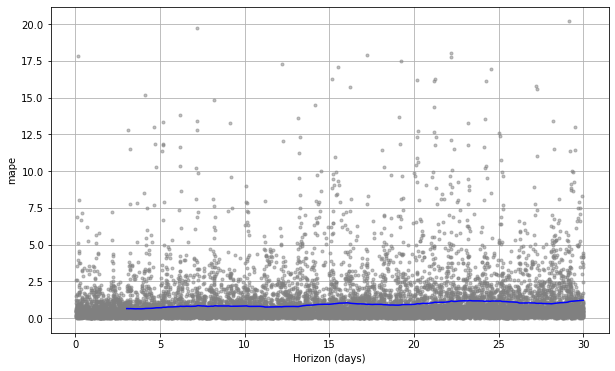

In [6]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [7]:
# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

MAPE = 92.5130122646828%
SMAPE = 15.365166648530598%


In [8]:
import pickle
pkl_path = "franklin-d-roosevelt/PM10_hourly_m.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

# save the dataframe
forecast.to_pickle("franklin-d-roosevelt/PM10_hourly_forecast.pkl")
print("*** Data Saved ***")

*** Data Saved ***
